In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import convolve2d as conv2
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import Angle
import udft

from surfh.Simulation import simulation_data
from surfh.DottestModels import MCMO_SigRLSCT_Model
from surfh.ToolsDir import utils

from surfh.Simulation import fusion_CT
from surfh.Models import instru
from surfh.ToolsDir import fusion_mixing

from surfh.Models import wavelength_mrs, realmiri

import pathlib
from jwst import datamodels

from skimage.measure import label


### Surfh model initialization

First we create MRS model for 

In [2]:
"""
Create Model and simulation
"""
origin_alpha_axis, origin_beta_axis, wavel_axis, spsf, maps, templates = simulation_data.get_simulation_data(4, 0, '../cube_orion/') # subsampling to reduce dim of maps

wavelength_1c = wavelength_mrs.get_mrs_wavelength('1c')
# n = len(wavelength_1c)
# x_original = np.arange(n)
# x_oversampled = np.linspace(0, n - 1, 2 * n - 1)
# oversampled_vector = np.interp(x_oversampled, x_original, original_vector)


with fits.open('/home/nmonnier/Data/JWST/Orion_bar/Stage_2/jw01288002001_0211f_00001_mirifushort_cal.fits') as hdul:
    hdr = hdul[1].header
    targ_ra  = hdr['RA_V1']
    targ_dec = hdr['DEC_V1']


orgin_target = instru.Coord(targ_ra, targ_dec)
ch1c, targ_ra, targ_dec = realmiri.get_IFU('/home/nmonnier/Data/JWST/Orion_bar/Stage_3/ChannelCube_ch1-long_s3d.fits')
step = 0.025
step_angle = Angle(step, u.arcsec).degree
ch1c_pix = ch1c.pix(step_angle)

# Super resolution factor (in alpha dim) 
super_resolution_factor = instru.get_srf(
    [ch1c.det_pix_size],
    step_angle*3600, # Conversion in arcsec
)

alpha_axis = origin_alpha_axis - np.mean(origin_alpha_axis) + targ_ra
beta_axis = origin_beta_axis - np.mean(origin_beta_axis) + targ_dec
pointings = instru.CoordList([orgin_target]).pix(step_angle)
from surfh.DottestModels import MCMO_SigRLSCT_Channel_Model
# Channel 
a = wavelength_1c[0] - np.flip((np.arange(10)+1))*(wavelength_1c[1]-wavelength_1c[0])*10
b = wavelength_1c[-1] + (np.arange(10)+1)*(wavelength_1c[-1]-wavelength_1c[-2])*10

global_wavelength = np.copy(wavelength_1c)
global_wavelength = np.append(global_wavelength, b)
global_wavelength = np.insert(global_wavelength, 0, a)

print(f'Wavelength resolution is {wavelength_1c[1]-wavelength_1c[0]}')
print("wavelength_1c size is", wavelength_1c.shape)
print("Global wavelenfth size is", global_wavelength.shape)
print(wavelength_1c)
print(global_wavelength)
channels = [
            MCMO_SigRLSCT_Channel_Model.Channel(
                ch1c,
                alpha_axis,
                beta_axis,
                global_wavelength,
                super_resolution_factor[0],
                pointings,
                step_angle
            )
        ]

print(f'Slit O-Shape channel 1C : {channels[0].oshape}')
print(f'Slit I-Shape channel 1C : {channels[0].ishape}')
print(ch1c.slit_fov[1].local.alpha_width)
print(f'Shape of Channel 1C output is ')

2024-09-11 11:25:20.117 | INFO     | surfh.Models.instru:pix:684 - IFU. 1C pixelized to 6.9e-06
2024-09-11 11:25:20.118 | INFO     | surfh.Models.instru:pix:684 - IFU. 1C pixelized to 6.9e-06


2
step =  0.025
[0.196]
Wavelength resolution is 0.0007999999797903001
wavelength_1c size is (1400,)
Global wavelenfth size is (1420,)
[6.53040021 6.53120021 6.53200021 ... 7.64800018 7.64880018 7.64960018]
[6.45040021 6.45840021 6.46640021 ... 7.71360018 7.72160018 7.72960018]
Slit O-Shape channel 1C : (1, 21, 1400, 19)
Slit I-Shape channel 1C : (1420, 251, 251)
0.0008888888888888889
Shape of Channel 1C output is 


2024-09-11 11:25:21.041625: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


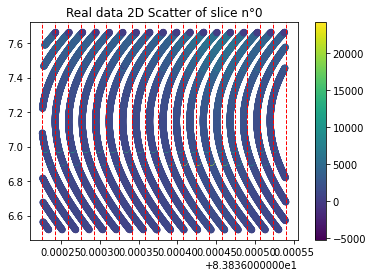

Min alpha is 83.83622662239941, Max alpha is 83.8365391196923
Range alpha is 0.0003124972928958414


In [3]:
model=datamodels.open('/home/nmonnier/Data/JWST/Orion_bar/Stage_2/jw01288002001_0211f_00001_mirifushort_cal.fits')
data = model.data

x_shape = data.shape[0]
y_shape = data.shape[1]

x_pixel_idx = np.arange(x_shape)
y_pixel_idx = np.arange(y_shape)

yy, xx = np.meshgrid(x_pixel_idx, y_pixel_idx)

detector2world = model.meta.wcs.get_transform('detector', 'world')

coordinates = detector2world(xx, yy)
test = detector2world(120,120)
binary_grid = np.zeros_like(data)


binary_grid[~np.isnan(coordinates[0].T)] = 1
# Label connected components: Identify and label the white regions
label_image = label(binary_grid)

pixel_set = np.where(label_image==10)

list_alpha = []
list_beta = []
list_lam = []
alpha, beta, lam = detector2world(pixel_set[1],pixel_set[0])

intensity = data[pixel_set]
#plt.figure(figsize=(2, 8))
sc = plt.scatter(alpha, lam, c=intensity)
plt.colorbar(sc)
plt.title(f"Real data 2D Scatter of slice n°{0}")

surfh_alpha_coordinates = np.linspace(np.min(alpha), np.max(alpha), channels[0].oshape[-1] + 1)

for x in surfh_alpha_coordinates:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=1)



plt.show()
world2detector = model.meta.wcs.get_transform('world', 'detector')
world2detector(alpha[0], beta[0], lam[0])
print(f'Min alpha is {np.min(alpha)}, Max alpha is {np.max(alpha)}')
print(f'Range alpha is {np.max(alpha) - np.min(alpha)}')


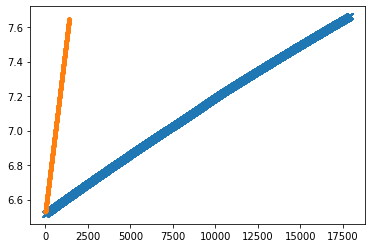

In [4]:
plt.plot(lam, 'x')
plt.plot(wavelength_1c, '.')
plt.show()

## Interpolation

In [5]:
surfh_alpha_coordinates = np.linspace(np.min(alpha), np.max(alpha), channels[0].oshape[-1])

step_size = surfh_alpha_coordinates[1] - surfh_alpha_coordinates[0]

# Extend the vector
extended_surfh_alpha_coordinates = np.concatenate((
    [surfh_alpha_coordinates[0] - step_size],  # Add one element before
    surfh_alpha_coordinates,                   # Original coordinates
    [surfh_alpha_coordinates[-1] + step_size]  # Add one element after
))

print(surfh_alpha_coordinates)
print(f'Range surfh alpha = {np.max(surfh_alpha_coordinates) - np.min(surfh_alpha_coordinates)}')
print(f"Difference is {(np.max(alpha) - np.min(alpha))- (np.max(surfh_alpha_coordinates) - np.min(surfh_alpha_coordinates))}")
print(f'Step surfh_alpha_coordinates is {surfh_alpha_coordinates[1] - surfh_alpha_coordinates[0]}')
surfh_lambda_coordinates = wavelength_1c

alpha, beta, lam = detector2world(pixel_set[1],pixel_set[0])
intensity = data[pixel_set]

print(type(alpha), type(lam), type(intensity))

[83.83622662 83.83624398 83.83626134 83.83627871 83.83629607 83.83631343
 83.83633079 83.83634815 83.83636551 83.83638287 83.83640023 83.83641759
 83.83643495 83.83645231 83.83646968 83.83648704 83.8365044  83.83652176
 83.83653912]
Range surfh alpha = 0.0003124972928958414
Difference is 0.0
Step surfh_alpha_coordinates is 1.736096071169868e-05
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


alpha_mesh_shape = (1400, 21)
There is 17886 samples
alpha_valid[1000] = 83.83650221299368, lambda_valid[1000] = 7.191785732559795, intensity_valid[1000] = 1741.8775634765625
alpha_valid[1000] = 83.83650221299368, lambda_valid[1000] = 7.191785732559795, intensity_valid[1000] = 1741.8775634765625


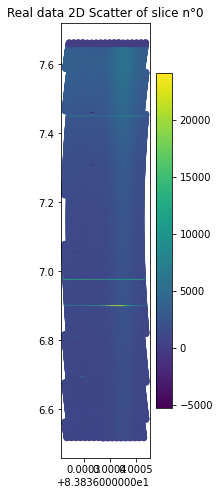

Min alpha is 83.83622662239941, Max alpha is 83.8365391196923


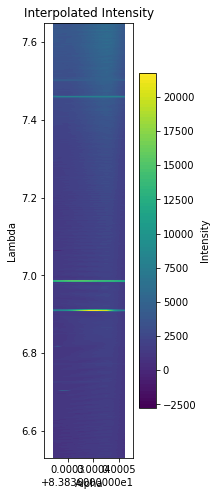

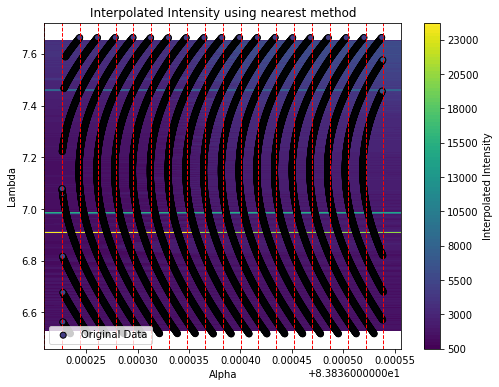

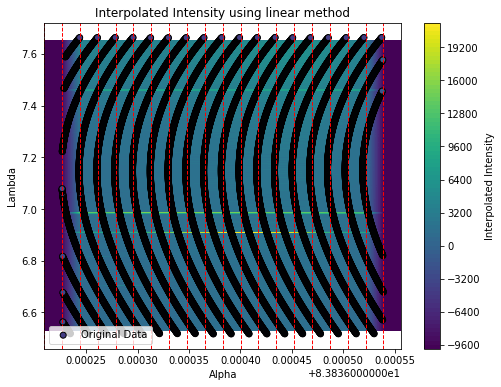

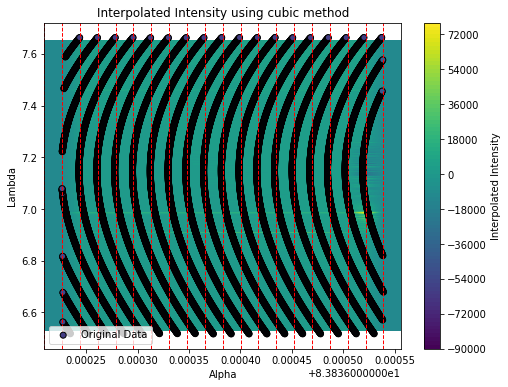

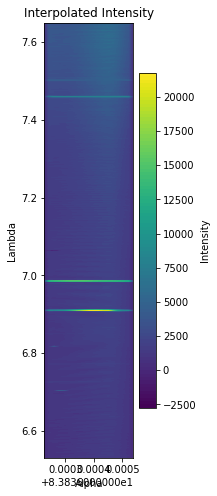

Shape intensity_grid =  (1400, 19)
Max intentity_grid =  21540.543661439962


In [6]:
# Create a meshgrid from the output grid
alpha_mesh, lambda_mesh = np.meshgrid(extended_surfh_alpha_coordinates, surfh_lambda_coordinates)
print("alpha_mesh_shape =", alpha_mesh.shape)

# Remove points where intensity is nan
valid_mask = ~np.isnan(intensity)
alpha_valid = alpha[valid_mask]
lambda_valid = lam[valid_mask]
intensity_valid = intensity[valid_mask]

print(f"There is {len(intensity_valid)} samples")
print(f'alpha_valid[1000] = {alpha_valid[10000]}, lambda_valid[1000] = {lambda_valid[10000]}, intensity_valid[1000] = {intensity_valid[10000]}')
# intensity_valid[10000] = 500000
print(f'alpha_valid[1000] = {alpha_valid[10000]}, lambda_valid[1000] = {lambda_valid[10000]}, intensity_valid[1000] = {intensity_valid[10000]}')



from scipy.interpolate import griddata
# Interpolate the data onto the grid
intensity_grid = griddata((alpha_valid, lambda_valid), intensity_valid, (alpha_mesh, lambda_mesh), method='linear')
plt.figure(figsize=(2, 8))
sc = plt.scatter(alpha_valid, lambda_valid, c=intensity_valid)
plt.colorbar(sc)
plt.title(f"Real data 2D Scatter of slice n°{0}")
plt.show()
world2detector = model.meta.wcs.get_transform('world', 'detector')
world2detector(alpha_valid[0], beta[0], lambda_valid[0])
print(f'Min alpha is {np.min(alpha_valid)}, Max alpha is {np.max(alpha_valid)}')
plt.show()

# Plot the result
plt.figure(figsize=(2, 8))
plt.contourf(alpha_mesh, lambda_mesh, intensity_grid, levels=100, cmap='viridis')
plt.colorbar(label='Intensity')
plt.xlabel('Alpha')
plt.ylabel('Lambda')
plt.title('Interpolated Intensity')
plt.show()



# Try different interpolation methods
methods = ['nearest', 'linear', 'cubic']

for method in methods:
    intensity_grid = griddata((alpha_valid, lambda_valid), intensity_valid, (alpha_mesh, lambda_mesh), method=method, fill_value=-10000)

    plt.figure(figsize=(8, 6))
    plt.contourf(alpha_mesh, lambda_mesh, intensity_grid, levels=100, cmap='viridis')
    plt.colorbar(label='Interpolated Intensity')
    plt.scatter(alpha_valid, lambda_valid, c=intensity_valid, edgecolor='black', label='Original Data')
    for x in extended_surfh_alpha_coordinates:
        plt.axvline(x=x, color='red', linestyle='--', linewidth=1)

    plt.xlabel('Alpha')
    plt.ylabel('Lambda')
    plt.title(f'Interpolated Intensity using {method} method')
    plt.legend()
    plt.show()


# Interpolate the data onto the grid

intensity_grid = griddata((alpha_valid, lambda_valid), intensity_valid, (alpha_mesh, lambda_mesh), method='linear', fill_value=0)

# Plot the result
plt.figure(figsize=(2, 8))
plt.contourf(alpha_mesh[:,1:-1], lambda_mesh[:,1:-1], intensity_grid[:,1:-1], levels=100, cmap='viridis')
plt.colorbar(label='Intensity')
plt.xlabel('Alpha')
plt.ylabel('Lambda')
plt.title('Interpolated Intensity')
plt.show()
print("Shape intensity_grid = ", intensity_grid[:,1:-1].shape)
print("Max intentity_grid = ", np.max(intensity_grid))


In [7]:
def distance(p1, p2):
    """Compute the Euclidean distance between two points."""
    return np.linalg.norm(np.array(p1) - np.array(p2))

def exponential_weight(dist, p=2, alpha=2.0):
    """
    Compute the exponential weight for a given distance.
    
    Parameters:
    dist: The distance between points.
    p: The power to raise the distance to (typically 2 for inverse distance).
    alpha: The exponential factor that controls the steepness.
    
    Returns:
    The weight associated with the distance.
    """
    return np.exp(-alpha * dist**p)

def exponential_modified_shepard(points, values, query_points, p=2, alpha=2.0, radius_cutoff=None, epsilon=1e-6):
    """
    Apply the Exponential Modified-Shepard interpolation method over a grid.
    
    Parameters:
    points: Tuple of (alpha, lambda) valid coordinates.
    values: Values at the known data points (intensity).
    query_points: Tuple of meshgrid (alpha_mesh, lambda_mesh) for interpolation.
    p: The power for inverse distance weighting (default is 2).
    alpha: The exponential decay factor (default is 2.0).
    radius_cutoff: The cutoff radius for influence. Points further than this radius will not be considered.
    epsilon: A small value to avoid division by zero.
    
    Returns:
    Interpolated intensity values for the entire grid.
    """
    alpha_mesh, lambda_mesh = query_points
    interpolated_values = np.zeros_like(alpha_mesh)
    
    # Iterate over each point in the grid
    for i in range(alpha_mesh.shape[0]):
        for j in range(alpha_mesh.shape[1]):
            query_point = (alpha_mesh[i, j], lambda_mesh[i, j])
            
            # Initialize numerator and denominator for Shepard's method
            numerator = 0.0
            denominator = 0.0
            
            # Iterate over known points and compute weights
            for k in range(len(values)):
                pt = (points[0][k], points[1][k])
                dist = distance(pt, query_point) + epsilon  # Avoid division by zero
                
                # Apply cutoff if specified
                if radius_cutoff is None or dist <= radius_cutoff:
                    w = exponential_weight(dist, p=p, alpha=alpha)
                    
                    numerator += w * values[k]
                    denominator += w
            
            # Store interpolated value at this grid point
            interpolated_values[i, j] = numerator / denominator if denominator != 0 else 0.0
    
    return interpolated_values


In [8]:
# intensity = data[pixel_set]
# alpha_valid = alpha[valid_mask]
# lambda_valid = lam[valid_mask]
# intensity_valid = intensity[valid_mask]

# points = (alpha_valid, lambda_valid)
# values = intensity_valid

# surfh_alpha_coordinates = np.linspace(np.min(alpha), np.max(alpha), channels[0].oshape[-1])
# surfh_lambda_coordinates = wavelength_1c

# alpha_mesh, lambda_mesh = np.meshgrid(surfh_alpha_coordinates, surfh_lambda_coordinates)
# query_points = (alpha_mesh, lambda_mesh)

# # Set parameters for interpolation
# p = 2            # Power for inverse distance weighting
# alpha = 2.0      # Exponential decay factor
# radius_cutoff = 0.0003124972928958414  # Optional cutoff radius to limit influence area


# # Perform interpolation on the grid
# interpolated_values = exponential_modified_shepard(points, values, query_points, p=p, alpha=alpha, radius_cutoff=radius_cutoff)

# print("Interpolated intensity values:\n", interpolated_values)


In [9]:
def pixel_distance(p1, p2, alpha_res, lambda_res):
    """
    Compute the pixel distance between two points, scaled according to the resolution of alpha and lambda.
    
    Parameters:
    p1, p2: The two points between which the distance is computed (each is a tuple of (alpha, lambda)).
    alpha_res: The resolution (pixel size) in the alpha direction.
    lambda_res: The resolution (pixel size) in the lambda direction.
    
    Returns:
    The distance in pixel units.
    """
    return np.sqrt(((p1[0] - p2[0]) / alpha_res) ** 2 + ((p1[1] - p2[1]) / lambda_res) ** 2)

def exponential_weight(dist, p=2, alpha=2.0):
    """
    Compute the exponential weight for a given distance.
    
    Parameters:
    dist: The pixel distance between points.
    p: The power to raise the distance to (typically 2 for inverse distance).
    alpha: The exponential factor that controls the steepness.
    
    Returns:
    The weight associated with the distance.
    """
    return np.exp(-alpha * dist**p)

def exponential_modified_shepard(points, values, query_points, p=2, alpha=2.0, pixel_cutoff=None, alpha_res=1.0, lambda_res=1.0, epsilon=1e-6):
    """
    Apply the Exponential Modified-Shepard interpolation method over a grid.
    
    Parameters:
    points: Tuple of (alpha, lambda) valid coordinates.
    values: Values at the known data points (intensity).
    query_points: Tuple of meshgrid (alpha_mesh, lambda_mesh) for interpolation.
    p: The power for inverse distance weighting (default is 2).
    alpha: The exponential decay factor (default is 2.0).
    pixel_cutoff: The cutoff radius in pixels for influence. Points further than this cutoff will not be considered.
    alpha_res: The resolution in the alpha direction (e.g., pixel width).
    lambda_res: The resolution in the lambda direction (e.g., pixel height).
    epsilon: A small value to avoid division by zero.
    
    Returns:
    Interpolated intensity values for the entire grid.
    """
    alpha_mesh, lambda_mesh = query_points
    interpolated_values = np.zeros_like(alpha_mesh)
    
    # Iterate over each point in the grid
    for i in range(alpha_mesh.shape[0]):
        for j in range(alpha_mesh.shape[1]):
            query_point = (alpha_mesh[i, j], lambda_mesh[i, j])
            
            # Initialize numerator and denominator for Shepard's method
            numerator = 0.0
            denominator = 0.0
            
            # Iterate over known points and compute weights
            for k in range(len(values)):
                pt = (points[0][k], points[1][k])
                dist = pixel_distance(pt, query_point, alpha_res, lambda_res) + epsilon  # Avoid division by zero
                
                # Apply pixel cutoff if specified
                if pixel_cutoff is None or dist <= pixel_cutoff:
                    w = exponential_weight(dist, p=p, alpha=alpha)
                    
                    numerator += w * values[k]
                    denominator += w
            
            # Store interpolated value at this grid point
            interpolated_values[i, j] = numerator / denominator if denominator != 0 else 0.0
    
    return interpolated_values


In [10]:
intensity = data[pixel_set]
alpha_valid = alpha[valid_mask]
lambda_valid = lam[valid_mask]
intensity_valid = intensity[valid_mask]

points = (alpha_valid, lambda_valid)
values = intensity_valid

surfh_alpha_coordinates = np.linspace(np.min(alpha), np.max(alpha), channels[0].oshape[-1])
surfh_lambda_coordinates = wavelength_1c

alpha_mesh, lambda_mesh = np.meshgrid(surfh_alpha_coordinates, surfh_lambda_coordinates)
query_points = (alpha_mesh, lambda_mesh)

# Set parameters for interpolation
p = 2            # Power for inverse distance weighting
alpha_exp = 2.0  # Exponential decay factor
pixel_cutoff = 2 # Radius cutoff in pixels

# Define pixel resolution in both directions (based on your grid structure)
alpha_res = (np.max(surfh_alpha_coordinates) - np.min(surfh_alpha_coordinates)) / alpha_mesh.shape[1]
lambda_res = (np.max(surfh_lambda_coordinates) - np.min(surfh_lambda_coordinates)) / lambda_mesh.shape[0]

# Perform interpolation on the grid
interpolated_values = exponential_modified_shepard(
    points, values, query_points, p=p, alpha=alpha_exp, pixel_cutoff=pixel_cutoff, alpha_res=alpha_res, lambda_res=lambda_res
)

print("Interpolated intensity values:\n", interpolated_values)


Interpolated intensity values:
 [[ 922.79688143  891.91855414  874.7478186  ... 1052.97449758
   990.2626292   995.76097902]
 [ 937.8461969   931.00468922  900.80014295 ... 1071.31373865
   924.31507835  867.57999295]
 [ 961.547704   1018.77184687  962.78409624 ... 1070.35980244
   895.99772811  833.14739643]
 ...
 [3570.47788139 3558.53571762 3506.14866252 ... 4076.49682967
  3736.60883426 3359.24798078]
 [3613.11433779 3604.17904397 3555.77082807 ... 4157.50865948
  3733.35515721 3401.90463221]
 [3674.89117336 3665.66330502 3579.62287192 ... 4227.39949809
  3725.7432045  3254.0800049 ]]


In [31]:
interpolated_values.shape
%matplotlib
plt.figure(figsize=(8,8))

plt.imshow(np.flipud(interpolated_values), aspect = 0.2)
plt.colorbar()
plt.show()

Using matplotlib backend: TkAgg


In [11]:
# from scipy.interpolate import Rbf

# # Flatten the grid for input to Rbf
# alpha_flat = alpha_mesh.ravel()
# lambda_flat = lambda_mesh.ravel()

# # Apply Rbf interpolation
# rbf_interpolator = Rbf(alpha_valid, lambda_valid, intensity_valid, function='linear')
# intensity_grid = rbf_interpolator(alpha_flat, lambda_flat)

# # Reshape the intensity grid back to 2D
# intensity_grid = intensity_grid.reshape(alpha_mesh.shape)

# # Plot the interpolated data
# plt.figure(figsize=(2, 8))
# plt.contourf(alpha_mesh, lambda_mesh, intensity_grid, levels=100, cmap='viridis')
# plt.colorbar(label='Interpolated Intensity')
# #plt.scatter(alpha_valid, lambda_valid, c=intensity_valid, edgecolor='black', label='Original Data')
# plt.xlabel('Alpha')
# plt.ylabel('Lambda')
# plt.title('Interpolated Intensity using Rbf')
# plt.legend()
# plt.show()

# # Print max intensity in the interpolated grid
# print("Max intensity_grid =", np.max(intensity_grid))


In [12]:
# Calculate the distance between each point in alpha_valid and each point in surfh_alpha_coordinates
distances = np.abs(alpha_valid[:, np.newaxis] - surfh_alpha_coordinates)

# Find the index of the nearest neighbor in surfh_alpha_coordinates for each point in alpha_valid
nearest_neighbors = np.argmin(distances, axis=1)

# Count how many times each surfh_alpha_coordinate is the nearest neighbor
counts = np.bincount(nearest_neighbors, minlength=len(surfh_alpha_coordinates))

# Display the result
for i, coord in enumerate(surfh_alpha_coordinates):
    print(f'Coordinate {coord} has {counts[i]} nearest neighbors in alpha_valid.')


Coordinate 83.83622662239941 has 490 nearest neighbors in alpha_valid.
Coordinate 83.83624398336012 has 1003 nearest neighbors in alpha_valid.
Coordinate 83.83626134432085 has 1006 nearest neighbors in alpha_valid.
Coordinate 83.83627870528156 has 1008 nearest neighbors in alpha_valid.
Coordinate 83.83629606624227 has 1006 nearest neighbors in alpha_valid.
Coordinate 83.836313427203 has 1009 nearest neighbors in alpha_valid.
Coordinate 83.8363307881637 has 1007 nearest neighbors in alpha_valid.
Coordinate 83.83634814912442 has 1006 nearest neighbors in alpha_valid.
Coordinate 83.83636551008514 has 1004 nearest neighbors in alpha_valid.
Coordinate 83.83638287104586 has 1008 nearest neighbors in alpha_valid.
Coordinate 83.83640023200657 has 1007 nearest neighbors in alpha_valid.
Coordinate 83.8364175929673 has 1006 nearest neighbors in alpha_valid.
Coordinate 83.836434953928 has 1006 nearest neighbors in alpha_valid.
Coordinate 83.83645231488872 has 1002 nearest neighbors in alpha_valid.

Original Labeled Image:
Sorted Labeled Image:


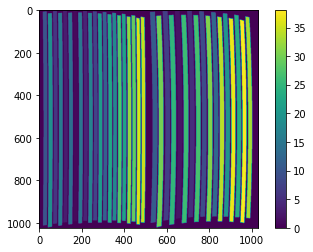

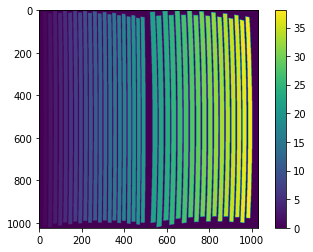

In [13]:
from scipy.ndimage import label, find_objects, center_of_mass

# Get the number of labels and label slices
num_labels = label_image.max()

# Compute the center of mass for each labeled region
centroids = center_of_mass(label_image, label_image, range(1, num_labels + 1))

# Sort labels by the x-coordinate (column index) of the centroids
sorted_labels = np.argsort([centroid[1] for centroid in centroids]) + 1

# Create a new labeled image with the labels sorted from left to right
sorted_labeled_image = np.zeros_like(label_image)
for new_label, old_label in enumerate(sorted_labels, start=1):
    sorted_labeled_image[label_image == old_label] = new_label

print("Original Labeled Image:")
plt.imshow(label_image)
plt.colorbar()

print("Sorted Labeled Image:")
plt.figure()
plt.imshow(sorted_labeled_image)
plt.colorbar()
plt.show()


-----------------------------------
-----------------------------------
Idx = 1
Min alpha = 83.83622662239941, max alpha =  83.8365391196923
Alpha = [83.83637375 83.83639112 83.83640848 ... 83.83626104 83.83627833
 83.83629562]
Coordinate 83.8362092614387 has 0 nearest neighbors in alpha_valid.
Coordinate 83.83622662239941 has 490 nearest neighbors in alpha_valid.
Coordinate 83.83624398336012 has 1003 nearest neighbors in alpha_valid.
Coordinate 83.83626134432085 has 1006 nearest neighbors in alpha_valid.
Coordinate 83.83627870528156 has 1008 nearest neighbors in alpha_valid.
Coordinate 83.83629606624227 has 1006 nearest neighbors in alpha_valid.
Coordinate 83.836313427203 has 1009 nearest neighbors in alpha_valid.
Coordinate 83.8363307881637 has 1007 nearest neighbors in alpha_valid.
Coordinate 83.83634814912442 has 1006 nearest neighbors in alpha_valid.
Coordinate 83.83636551008514 has 1004 nearest neighbors in alpha_valid.
Coordinate 83.83638287104586 has 1008 nearest neighbors in a

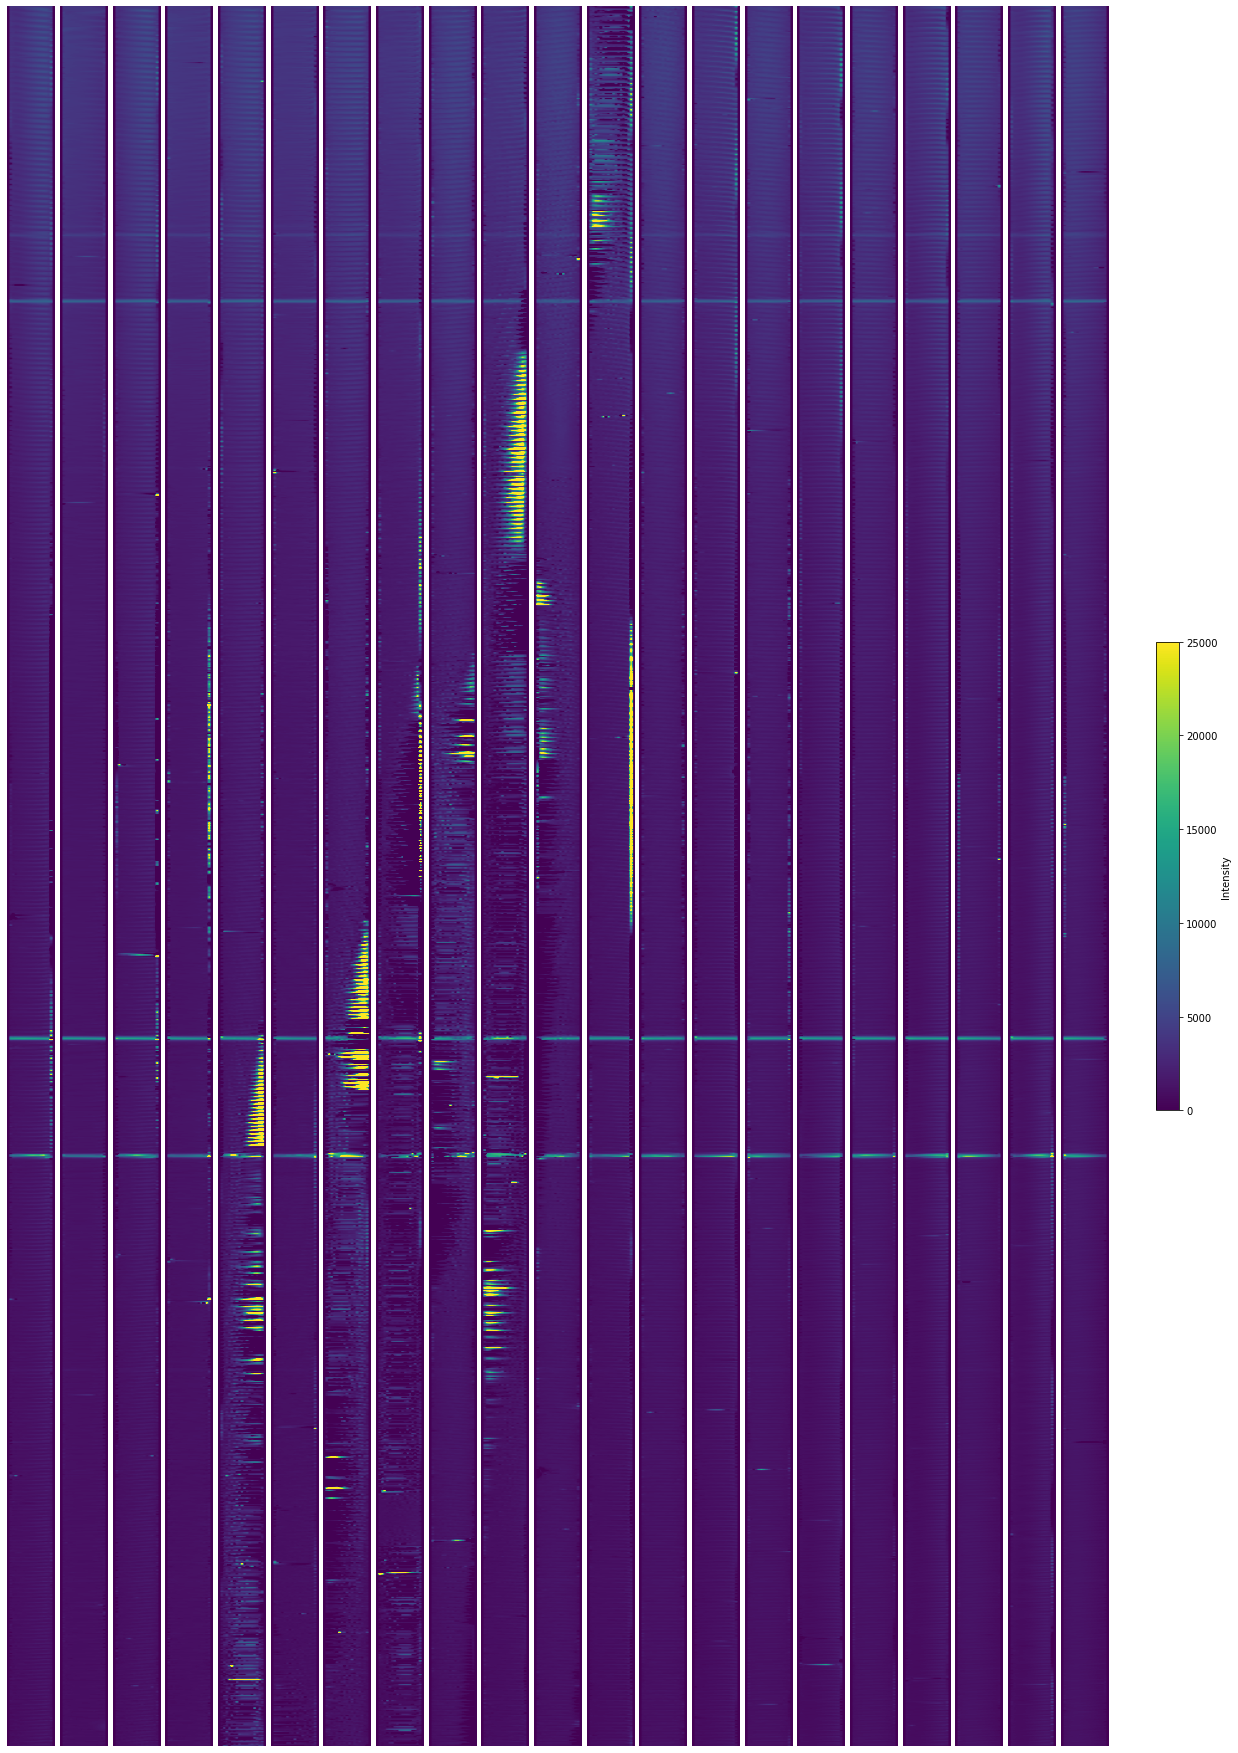

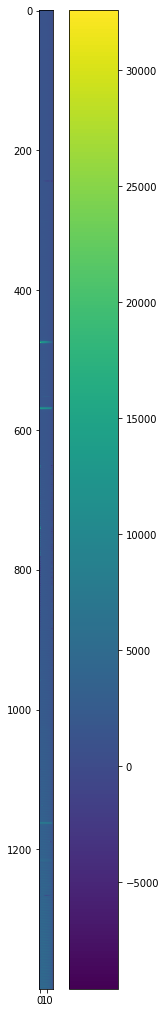

In [14]:

# Number of images (bars)
n = channels[0].oshape[1]

# Space between images (as a fraction of image width)
space = 0.1

# Create a figure with a specified width and height
fig, ax = plt.subplots(figsize=(n * 1, 32))

# Set the axis off
ax.axis('off')
vmin = 0
vmax = 25000

list_intensity_grid = []
for slit in range(len(np.unique(sorted_labeled_image))):
    print("-----------------------------------")
    if slit == 0:
        continue
    pixel_set = np.where(sorted_labeled_image==slit)
    alpha, beta, lam = detector2world(pixel_set[1],pixel_set[0])
    if np.any(lam > 9):
        continue
    
    print(f"Idx = {slit}")
    list_alpha = []
    list_beta = []
    
    
    surfh_alpha_coordinates = np.linspace(np.min(alpha), np.max(alpha), channels[0].oshape[-1])
    step_size = surfh_alpha_coordinates[1] - surfh_alpha_coordinates[0]

    # Extend the vector
    extended_surfh_alpha_coordinates = np.concatenate((
        [surfh_alpha_coordinates[0] - step_size],  # Add one element before
        surfh_alpha_coordinates,                   # Original coordinates
        [surfh_alpha_coordinates[-1] + step_size]  # Add one element after
    ))
    print(f'Min alpha = {np.min(alpha)}, max alpha =  {np.max(alpha)}')
    print(f'Alpha = {alpha}')
    surfh_lambda_coordinates = wavelength_1c

    alpha, beta, lam = detector2world(pixel_set[1],pixel_set[0])
    intensity = data[pixel_set]


    # Create a meshgrid from the output grid
    alpha_mesh, lambda_mesh = np.meshgrid(extended_surfh_alpha_coordinates, surfh_lambda_coordinates)

    # Remove points where intensity is nan
    valid_mask = ~np.isnan(intensity)
    alpha_valid = alpha[valid_mask]
    lambda_valid = lam[valid_mask]
    intensity_valid = intensity[valid_mask]

    # Interpolate the data onto the grid


    intensity_grid = griddata((alpha_valid, lambda_valid), intensity_valid, (alpha_mesh, lambda_mesh), method='cubic', fill_value=0)
    intensity_grid = intensity_grid[:,1:-1]
    list_intensity_grid.append(intensity_grid)



    # Calculate the distance between each point in alpha_valid and each point in surfh_alpha_coordinates
    distances = np.abs(alpha_valid[:, np.newaxis] - extended_surfh_alpha_coordinates)

    # Find the index of the nearest neighbor in surfh_alpha_coordinates for each point in alpha_valid
    nearest_neighbors = np.argmin(distances, axis=1)

    # Count how many times each surfh_alpha_coordinate is the nearest neighbor
    counts = np.bincount(nearest_neighbors, minlength=len(extended_surfh_alpha_coordinates))

    # Display the result
    for i, coord in enumerate(extended_surfh_alpha_coordinates):
        print(f'Coordinate {coord} has {counts[i]} nearest neighbors in alpha_valid.')




    # Calculate the left and right positions with space in between
    left = slit-1 + (slit-1) * space
    right = left + 1
    height = len(surfh_lambda_coordinates)  # height of the image
    im = ax.imshow(np.flipud(intensity_grid), extent=[left, right, 0, height], aspect='auto', vmin=vmin, vmax=vmax, cmap='viridis')

ax.set_xlim(0, n + (n - 1) * space)
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Intensity')


plt.show()

plt.figure(figsize=(6,18))
plt.imshow(intensity_grid)
plt.colorbar()
plt.show()

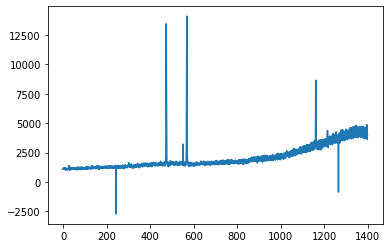

In [15]:
plt.figure()
plt.plot(intensity_grid[:, 10])
plt.show()

In [16]:
%matplotlib
for slit in range(len(np.unique(sorted_labeled_image))):
    print("-----------------------------------")
    if slit == 0:
        continue
    pixel_set = np.where(sorted_labeled_image==slit)
    alpha, beta, lam = detector2world(pixel_set[1],pixel_set[0])
    if np.any(lam > 9):
        continue
    
    print(f"Idx = {slit}")
    list_alpha = []
    list_beta = []
    
    
    surfh_alpha_coordinates = np.linspace(np.min(alpha), np.max(alpha), channels[0].oshape[-1])
    step_size = surfh_alpha_coordinates[1] - surfh_alpha_coordinates[0]

    # Extend the vector
    extended_surfh_alpha_coordinates = np.concatenate((
        [surfh_alpha_coordinates[0] - step_size],  # Add one element before
        surfh_alpha_coordinates,                   # Original coordinates
        [surfh_alpha_coordinates[-1] + step_size]  # Add one element after
    ))
    print(f'Min alpha = {np.min(alpha)}, max alpha =  {np.max(alpha)}')
    print(f'Alpha = {alpha}')
    surfh_lambda_coordinates = wavelength_1c

    alpha, beta, lam = detector2world(pixel_set[1],pixel_set[0])
    intensity = data[pixel_set]


    # Create a meshgrid from the output grid
    alpha_mesh, lambda_mesh = np.meshgrid(extended_surfh_alpha_coordinates, surfh_lambda_coordinates)

    # Remove points where intensity is nan
    valid_mask = ~np.isnan(intensity)
    alpha_valid = alpha[valid_mask]
    lambda_valid = lam[valid_mask]
    intensity_valid = intensity[valid_mask]

    # Interpolate the data onto the grid
    intensity_grid = griddata((alpha_valid, lambda_valid), intensity_valid, (alpha_mesh, lambda_mesh), method='linear', fill_value=0)
    
    # intensity_grid = intensity_grid[:,1:-1]
    list_intensity_grid.append(intensity_grid)

    if slit == 21:
        plt.figure(figsize=(8, 6))
        plt.contourf(alpha_mesh, lambda_mesh, intensity_grid, levels=100, cmap='viridis')
        plt.colorbar(label='Interpolated Intensity')
        plt.scatter(alpha_valid, lambda_valid, c=intensity_valid, edgecolor='black', label='Original Data')
        for x in extended_surfh_alpha_coordinates:
            plt.axvline(x=x, color='red', linestyle='--', linewidth=1)

        plt.xlabel('Alpha')
        plt.ylabel('Lambda')
        plt.title(f'Interpolated Intensity for slice {slit}')
        plt.legend()

        plt.figure(figsize=(2, 8))
        sc = plt.scatter(alpha_valid, lambda_valid, c=intensity_valid)
        plt.colorbar(sc)
        plt.title(f"Real data 2D Scatter of slice n°{0}")
        plt.show()
        world2detector = model.meta.wcs.get_transform('world', 'detector')
        world2detector(alpha_valid[0], beta[0], lambda_valid[0])
        print(f'Min alpha is {np.min(alpha_valid)}, Max alpha is {np.max(alpha_valid)}')
        
    plt.show()



Using matplotlib backend: <object object at 0x7ff3e047df40>
-----------------------------------
-----------------------------------
Idx = 1
Min alpha = 83.83622662239941, max alpha =  83.8365391196923
Alpha = [83.83637375 83.83639112 83.83640848 ... 83.83626104 83.83627833
 83.83629562]
-----------------------------------
Idx = 2
Min alpha = 83.83576457919389, max alpha =  83.8360766829887
Alpha = [83.8359457  83.83596251 83.83597929 ... 83.83583788 83.83585479
 83.83577026]
-----------------------------------
Idx = 3
Min alpha = 83.83627230549054, max alpha =  83.83658868662737
Alpha = [83.83628705 83.83630429 83.83632156 ... 83.83639571 83.83641306
 83.83627502]
-----------------------------------
Idx = 4
Min alpha = 83.8358060631392, max alpha =  83.83612365023302
Alpha = [83.83608225 83.83609995 83.83611764 ... 83.83587741 83.83589515
 83.83591289]
-----------------------------------
Idx = 5
Min alpha = 83.83631692933199, max alpha =  83.83663299821202
Alpha = [83.83632224 83.83633

## MRS Model

In [17]:
mrs_input = np.array(list_intensity_grid)
mrs_input = mrs_input[np.newaxis, ...]
print(mrs_input.shape)
print(len(list_intensity_grid))

output_grid = channels[0].sliceToCube(mrs_input)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (42, 1400) + inhomogeneous part.

In [ ]:
from matplotlib.widgets import Slider
# Initial lambda index
#%matplotlib
initial_lambda = 0
Lambda = output_grid.shape[0]
# Create a figure and axis
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.25)  # Adjust the subplot to make space for the slider

# Display the initial slice
slice_plot = ax.imshow(output_grid[initial_lambda, :, :], cmap='viridis')
ax.set_title(f'Lambda slice: {initial_lambda}')

# Add a colorbar
cbar = plt.colorbar(slice_plot, ax=ax)

# Create the slider axis and slider
ax_slider = plt.axes([0.1, 0.1, 0.8, 0.05], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Lambda', 0, Lambda-1, valinit=initial_lambda, valstep=1)

# Update function to be called when the slider is changed
def update(val):
    lambda_index = int(slider.val)
    slice_plot.set_data(output_grid[lambda_index, :, :])
    ax.set_title(f'Lambda slice: {lambda_index}')
    fig.canvas.draw_idle()

# Attach the update function to the slider
slider.on_changed(update)

plt.show()


In [ ]:
print(mrs_input.shape)
plt.figure()
plt.plot(mrs_input[0][0][15])
plt.show()

(1, 21, 1400, 19)
